## SoftMax for MNIST  

使用Numpy搭建，相比多个二分类器，显著提高了对于数字的分类成功率，发现loss在初期快速下降，最终实现了达92%的成功率，并画出了confusion matrix

- 读取文件，划分将训练集进行划分

In [91]:
import pickle
import gzip
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import os
import numpy as np
import seaborn as sns; sns.set()
np.random.seed(666)

### 数据与函数初始化 

In [92]:
filename = '../../dataset/mnist/mnist.pkl.gz'
f = gzip.open(filename, 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
f.close()

- 训练集基本情况

In [93]:
print(len(training_data[0][1]))

784


In [94]:
len(training_data[:1][0])

50000

In [95]:
# 前五个数据类别
print(training_data[1][:5])

[5 0 4 1 9]


In [96]:
# 总的类别数
classes = np.unique(training_data[1])
print(classes)

[0 1 2 3 4 5 6 7 8 9]


- 基本函数

In [97]:
def one_hot_vect(tuple_data,classes):
    one_hot_encoded=np.zeros((len(tuple_data[1]),len(classes)))
    identity = np.identity(len(classes))
    for i in range(len(tuple_data[1])):
        one_hot_encoded[i] = np.add(one_hot_encoded[i],identity[tuple_data[1][i]])
    return one_hot_encoded

In [98]:
def softmax(weights,train_data):
    bias = np.ones((np.shape(train_data)[0],1))
    train_withBias = np.hstack((train_data,bias))
    num = np.dot(weights,train_withBias.T)
    num = np.subtract(num,np.max(num,axis=0))
    num = np.exp(num)
    # Fix softmax when using batch size 1 the dimension of deno changes
    if(len(train_data) == 1):
        den = np.sum(num,axis=0)
    else:
        den = np.sum(num,axis=1)
        den = den.reshape((10,1))
    return np.divide(num,den)

In [99]:
def cross_entropy_error(predicted,target):
    right = np.log(predicted+ 1/10**30)
    loss = np.multiply(np.matrix(target),np.transpose(np.matrix(right)))
    return -np.sum(np.sum(loss,axis=1),axis=0)

def batch_gradient(predicted,train_data,target):
    leftleft = np.transpose(predicted)
    left = np.subtract(leftleft,target)
    bias = np.ones((np.shape(train_data)[0],1))
    train_withBias = np.hstack((train_data,bias))
    gradient = np.dot(left.T,train_withBias)
    gradient = gradient/len(train_data)
    return np.matrix(gradient,dtype="float64")

In [100]:
def accuracy(predicted,target):
    correct = 0
    left = np.array(np.argmax(predicted,axis=0)).flatten()
    right = np.argmax(target,axis=1)
    confusion_mat = np.zeros((len(np.unique(right)),len(np.unique(left))))
    for i in range(len(target)):
        if(left[i] == right[i]):
            correct+=1
        confusion_mat[right[i]][left[i]] =confusion_mat[right[i]][left[i]] +1
    return correct/len(target),pd.DataFrame(np.matrix(confusion_mat,dtype="int32"))

In [101]:
def more_metrics(conf_mat):
    true_positives = 0
    precision = []
    recall = []
    for i in range(len(conf_mat)):
        true_positives += conf_mat.iloc[i,i]
    conf_mat = np.matrix(conf_mat)
    tp_fp = np.array(np.sum(conf_mat,axis=1)).ravel()
    relevant_elements = np.array(np.sum(conf_mat,axis=0)).ravel()
    for i in range(len(conf_mat)):
        precision.append(conf_mat[i,i]/tp_fp[i])
        recall.append(conf_mat[i,i]/relevant_elements[i])
    return true_positives,precision,recall

In [102]:
def epoch_shuffle(processed_train_data,target):
    # Merge
    trainDF = pd.DataFrame(processed_train_data)
    targetDF = pd.DataFrame(target)
    result = pd.concat([trainDF.reset_index(),targetDF.reset_index()],join='inner',axis=1)
    result = result.sample(frac=1)
    
    return np.asarray(result.iloc[:,1:np.shape(trainDF)[1]+1]),np.asarray(result.iloc[:,np.shape(trainDF)[1]+2:])

- 参数初始化

In [103]:
weights = np.random.randn(len(classes), np.shape(training_data[0])[1]+1) * 0.001
train_data = training_data[0]

In [104]:
target = one_hot_vect(training_data,classes)
target_val = one_hot_vect(validation_data,classes)
target_test = one_hot_vect(test_data,classes)

### 数据处理与训练 

- 标准化归一

In [105]:
scaler = StandardScaler()
scaler.fit(train_data)
processed_train_data = scaler.transform(train_data)
scaler.fit(validation_data[0])
processed_val_data = scaler.transform(validation_data[0])
scaler.fit(test_data[0])
processed_test_data = scaler.transform(test_data[0])

In [106]:
batchSize = 1

In [107]:
start = 0
end = batchSize
batches = len(processed_train_data)/batchSize
weights = np.random.randn(len(classes), np.shape(training_data[0])[1]+1) * 0.001
predicted = softmax(weights,processed_train_data[start:end,:])
cost_initial = np.asscalar(cross_entropy_error(softmax(weights,processed_train_data),target))
cost_new = cost_initial*0.1
train_acc = 0
log_training_loss =[]
log_val_loss=[]
log_training_acc =[]
log_val_acc=[]
logging=True
while(cost_initial-cost_new > 10):
    i = 0
    start = 0
    end = batchSize
    while(i<batches-1):
        #print("Percentage Done: "+str(i/batches))
        new_weights = batch_gradient(predicted,processed_train_data[start:end,:],target[start:end,:])
        weights = weights - 0.0003*new_weights
        if(logging and i%2500==0):
            # Predict Train & Validation for these weights
            predict_val = softmax(weights,processed_val_data)
            # Calculate cost of predicting Validation and Training, To see if the hyper param are working
            acc,_  = accuracy(predict_val,target_val)
            log_val_acc.append(acc)
            log_val_loss.append(np.asscalar(cross_entropy_error(predict_val,target_val)))
            predict_train = softmax(weights,processed_train_data)
            acc,_  = accuracy(predict_train,target)
            log_training_acc.append(acc)
            log_training_loss.append(np.asscalar(cross_entropy_error(predict_train,target)))
        #print("Training Loss: "+str(cost))
        start = start + batchSize
        end = end + batchSize
        # New Prediction for the data
        predicted = softmax(weights,processed_train_data[start:end,:])
        i = i+1
    cost_initital = cost_new
    pred_train = softmax(weights,processed_train_data)
    cost_new = np.asscalar(cross_entropy_error(pred_train,target))
    predict_val = softmax(weights,processed_val_data)
    val_acc,_ = accuracy(predict_val,target_val)
    train_acc_old = train_acc
    train_acc,_ = accuracy(pred_train,target)
    if(float(train_acc) - float(train_acc_old) < 0.0000000001 ):
        # Early stopping where just cost is changing but accuracy is stuck
        break
    print("Cost after Epoch: "+str(cost_new))
    print("Val Acc: "+str(val_acc))
    print("Train Acc: "+str(train_acc))
    processed_train_data,target = epoch_shuffle(processed_train_data,target)

Cost after Epoch: 444485.6081337412
Val Acc: 0.9133
Train Acc: 0.90652
Cost after Epoch: 442570.49532211025
Val Acc: 0.9199
Train Acc: 0.91648
Cost after Epoch: 441727.6346208149
Val Acc: 0.9221
Train Acc: 0.91986
Cost after Epoch: 441178.8726038046
Val Acc: 0.9242
Train Acc: 0.9225
Cost after Epoch: 440891.25808155054
Val Acc: 0.9255
Train Acc: 0.92362
Cost after Epoch: 440567.9224549103
Val Acc: 0.9258
Train Acc: 0.92606
Cost after Epoch: 440361.46788030525
Val Acc: 0.9259
Train Acc: 0.92696
Cost after Epoch: 440192.3217471931
Val Acc: 0.9274
Train Acc: 0.92796
Cost after Epoch: 440029.42622406536
Val Acc: 0.9261
Train Acc: 0.92856
Cost after Epoch: 439932.5345147088
Val Acc: 0.9261
Train Acc: 0.92896
Cost after Epoch: 439798.71011219424
Val Acc: 0.9271
Train Acc: 0.92992
Cost after Epoch: 439742.1792981935
Val Acc: 0.927
Train Acc: 0.9301
Cost after Epoch: 439612.34039200965
Val Acc: 0.9272
Train Acc: 0.93076
Cost after Epoch: 439559.98509099515
Val Acc: 0.927
Train Acc: 0.93112
Cos

### 结果分析 

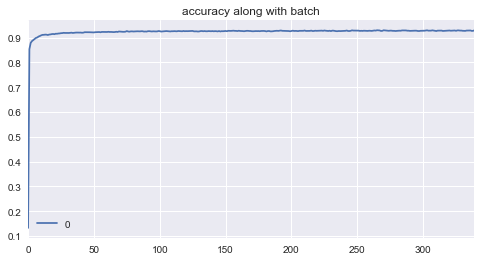

In [108]:
df = pd.DataFrame(log_val_acc)
ax = df.plot(figsize=(8,4))
ax.ticklabel_format(useOffset=False)
plt.title('accuracy along with batch')
plt.show(ax)

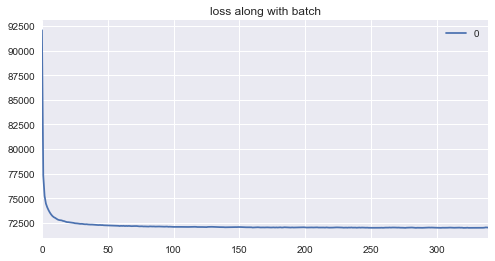

In [109]:
df = pd.DataFrame(log_val_loss)
ax = df.plot(figsize=(8,4))
ax.ticklabel_format(useOffset=False)
plt.title('loss along with batch')
plt.show(ax)

In [110]:
predict_val = softmax(weights,processed_val_data)
acc,conf_mat = accuracy(predict_val,target_val)

In [111]:
print("The Accuracy for Validation is: "+str(acc))
#print("The Confusion Matrix is: ")
#print(pd.DataFrame(conf_mat))
_,precision,recall = more_metrics(pd.DataFrame(conf_mat))
print("The Precision & Recall is: ")
df = pd.DataFrame(np.multiply(precision,100))
df.columns = ["Recall"]
df1 = pd.DataFrame(np.multiply(recall,100))
df1.columns = ["Precision"]
print(pd.concat([df,df1],axis=1))

The Accuracy for Validation is: 0.9278
The Precision & Recall is: 
      Recall  Precision
0  97.275479  96.303696
1  98.120301  93.548387
2  90.505051  93.821990
3  89.320388  91.360477
4  94.506612  93.554884
5  87.103825  89.249720
6  96.794209  95.025381
7  94.770642  93.146979
8  88.107037  90.992835
9  90.530697  90.248963


- Confusion Matrix

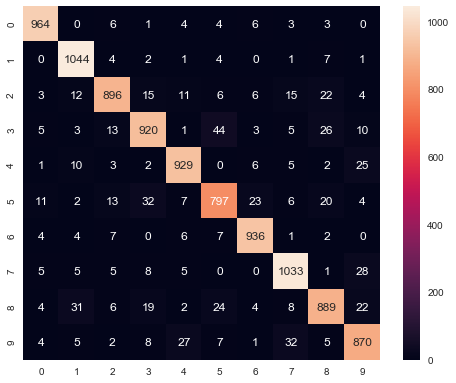

In [112]:
from IPython.core.pylabtools import figsize # import figsize
figsize(8, 6.5) # 设置 figsize
ax = sns.heatmap(conf_mat, annot=True, fmt="d")